In [2]:
import numpy as np
from scipy.special import erfc
from scipy.integrate import quad
from scipy.integrate import simpson
from scipy.integrate import fixed_quad

def integral_by_quad(lam_s, lam_t, lam_u, beta):
    """
    주어진 구간 [lam_s, lam_t]에서
    exp(lam - beta^2 * (lam - lam_u)**2)를
    수치적으로 적분하여 결과와 추정 오차를 반환.
    """

    def integrand(lam, lam_u, beta):
      """
      적분에 쓰일 integrand 함수.
      exp(lam - beta^2 * (lam - lam_u)^2)를 반환.
      """
      return np.exp(lam - beta**2 * (lam - lam_u)**2)

    val, err = quad(integrand, lam_s, lam_t, args=(lam_u, beta))
    return val

def integrate_exp_simpson(lam_s, lam_t, lam_u, beta, num_points=200):
    x_vals = np.linspace(lam_s, lam_t, num_points)
    y_vals = np.exp(x_vals - beta**2 * (x_vals - lam_u)**2)
    
    area = simpson(y_vals, x_vals)
    return area

def integrate_exp_fixed_quad(lam_s, lam_t, lam_u, beta, n=64):
    """
    n: 가우스-레장드르 점 개수
    """
    func = lambda lam: np.exp(lam - beta**2 * (lam - lam_u)**2)
    val, _ = fixed_quad(func, lam_s, lam_t, n=n)
    return val

def integral_by_closed(lam_s, lam_t, lam_u, beta):
    """
    [lam_s, lam_t] 구간에서
    exp(lam - beta^2*(lam - lam_u)^2) 적분의 닫힌형 해를 반환한다.
    """
    def log_erf_diff(a, b):
        return np.log(erfc(b)) + np.log(1.0-np.exp(np.log(erfc(a)) - np.log(erfc(b))))

    try:
        h = lam_t - lam_s
        s = 1 /(beta*h)
        r_u = (lam_u - lam_s) / h

        log_prefactor = lam_t + np.log(h) + ((s*h)**2/4 + h*(r_u-1)) + np.log(0.5*np.sqrt(np.pi)*s)
        upper = (r_u + s**2*h/2)/s
        lower = (r_u + s**2*h/2 - 1)/s
        return np.exp(log_prefactor + log_erf_diff(upper, lower))
    except:
        return np.nan

In [3]:
class GaussLegendre():
	"""
		x,w 리스트는 여기를 참조
		https://pomax.github.io/bezierinfo/legendre-gauss.html
	"""
	def __init__(self, f):
		self.f = f
		# [x, w]
		self.n2 = [-0.5773502691896257, 1], \
				  [0.5773502691896257, 1]
		self.n3 = [0, 0.8888888888888888],\
				  [-0.7745966692414834, 0.5555555555555556], \
				  [0.7745966692414834, 	0.5555555555555556]
		self.n4 = [-0.3399810435848563, 0.6521451548625461], \
				  [0.3399810435848563, 0.6521451548625461], \
				  [-0.8611363115940526, 0.3478548451374538], \
				  [0.8611363115940526, 0.3478548451374538]

	def calcular(self, numPontos):

		result = 0

		if numPontos == 2:
			x1 = self.n2[0][0]
			w1 = self.n2[0][1]

			result += w1 * self.f(x1)

			x2 = self.n2[1][0]
			w2 = self.n2[1][1]

			result += w2 * self.f(x2)

			return result

		elif numPontos == 3:

			x1 = self.n3[0][0]
			w1 = self.n3[0][1]

			result += w1 * self.f(x1)

			x2 = self.n3[1][0]
			w2 = self.n3[1][1]

			result += w2 * self.f(x2)

			x3 = self.n3[2][0]
			w3 = self.n3[2][1]

			result += w3 * self.f(x3)

			return result

		elif numPontos == 4:

			x1 = self.n4[0][0]
			w1 = self.n4[0][1]

			result += w1 * self.f(x1)

			x2 = self.n4[1][0]
			w2 = self.n4[1][1]

			result += w2 * self.f(x2)

			x3 = self.n4[2][0]
			w3 = self.n4[2][1]

			result += w3 * self.f(x3)

			x4 = self.n4[3][0]
			w4 = self.n4[3][1]

			result += w4 * self.f(x4)

			return result

def integral_by_quad_legendre(lam_s, lam_t, lam_u, beta):

    def gaussian(lam):
        return np.exp(lam - beta**2*(lam-lam_u)**2)
    f = lambda lam: (lam_t-lam_s)/2 * gaussian(lam*(lam_t-lam_s)/2 + (lam_s+lam_t)/2)
    metodoIntegracao = GaussLegendre(f=f)
    numPontos =  4
    valor_atual = metodoIntegracao.calcular(numPontos)
    return valor_atual

In [146]:
import numpy as np
import matplotlib.pyplot as plt

# 가정: integral_by_closed, integral_by_quad, integrate_exp_fixed_quad 
#      이 세 함수는 이미 정의되어 있다고 가정합니다.

# log_scales : -1 ~ 1 구간 10등분, Goal : -6 ~ 6 구간까지 증가시켜야함
log_scales = np.linspace(0, 3, 10)
scales = np.exp(log_scales)

# 하이퍼파라미터 설정
lam_min = -5.0778
lam_max =  5.7618            
lam_range = lam_max - lam_min

# n을 4부터 64까지 변화시키며 비교
n_values = range(4, 20)

diff_from_closed = []  # |inte0 - inte2| 합
diff_from_quad   = []  # |inte1 - inte2| 합

for n in n_values:
    total_diff_closed = 0.0  # 모든 NFE, step, r_u, beta에 대해 누적
    total_diff_quad   = 0.0

    for NFE in range(5, 31):      # 예시로 5부터 30까지
        for step in range(NFE):
            h = lam_range / NFE
            betas = 1/(scales*h)

            for r_u in [1, 0, -1, -2]:
                # 적분 구간 [lam_s, lam_t] 정의
                lam_s = lam_min + step * h
                lam_t = lam_min + (step + 1) * h
                lam_u = lam_s + r_u * h

                # 각각의 적분값 계산
                inte0 = np.array([integral_by_closed(lam_s, lam_t, lam_u, beta) 
                                  for beta in betas])  # 닫힌형 해
                inte1 = np.array([integral_by_quad(lam_s, lam_t, lam_u, beta) 
                                  for beta in betas])  # scipy.quad
                inte2 = np.array([integrate_exp_fixed_quad(lam_s, lam_t, lam_u, beta, n=n) 
                                  for beta in betas])  # fixed_quad (n변화)

                # 닫힌형 해(inte0)와의 차이
                total_diff_closed += np.sum(np.abs(inte0 - inte1))
                # scipy.quad(inte1)와의 차이
                total_diff_quad   += np.sum(np.abs(inte0 - inte2))

    diff_from_closed.append(total_diff_closed)
    diff_from_quad.append(total_diff_quad)


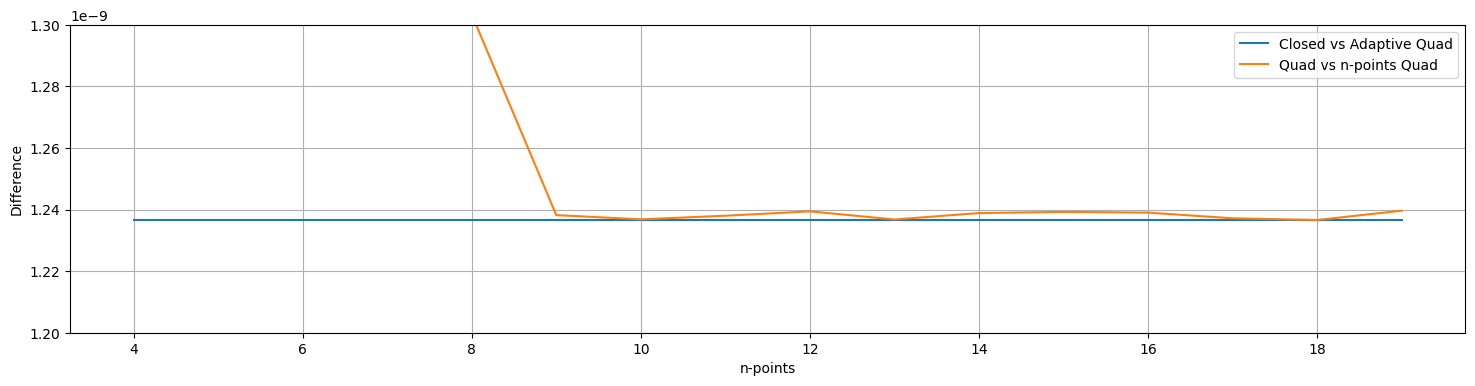

In [148]:
# 그래프 그리기
plt.figure(figsize=[18, 4])
plt.plot(n_values, diff_from_closed, label='Closed vs Adaptive Quad')
plt.plot(n_values, diff_from_quad,   label='Quad vs n-points Quad')
plt.xlabel('n-points')
plt.ylabel('Difference')
plt.legend()
plt.ylim([1.2e-9, 1.3e-9])
plt.grid()
plt.show()


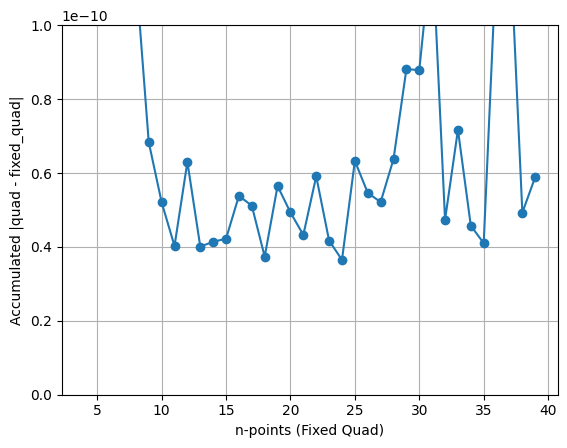

In [157]:
import numpy as np
import matplotlib.pyplot as plt

# 가정: integral_by_quad, integrate_exp_fixed_quad 
#      이 두 함수는 이미 정의되어 있다고 가정합니다.

# log_scales : -1 ~ 1 구간 10등분, Goal : -6 ~ 6 구간까지 증가시켜야함
log_scales = np.linspace(0, 6, 10)
scales = np.exp(log_scales)

# 하이퍼파라미터 설정
lam_min = -5.0778
lam_max =  5.7618            
lam_range = lam_max - lam_min

# n을 4부터 19까지 변화시키며 비교
n_values = range(4, 40)

# quad와 fixed_quad 간 차이를 누적할 리스트
diff_quad_fixed = []

for n in n_values:
    total_diff = 0.0  # 모든 NFE, step, r_u, beta에 대해 누적

    for NFE in range(5, 31):      # 예시로 5부터 30까지
        for step in range(NFE):
            h = lam_range / NFE
            betas = 1/(scales * h)

            for r_u in [1, 0, -1, -2]:
                # 적분 구간 [lam_s, lam_t] 정의
                lam_s = lam_min + step * h
                lam_t = lam_min + (step + 1) * h
                lam_u = lam_s + r_u * h

                # 각각의 적분값 계산
                inte1 = np.array([integral_by_quad(lam_s, lam_t, lam_u, beta) 
                                  for beta in betas])  # scipy.quad
                inte2 = np.array([integrate_exp_fixed_quad(lam_s, lam_t, lam_u, beta, n=n) 
                                  for beta in betas])  # fixed_quad (n변화)

                # quad(inte1)와 fixed_quad(inte2)의 차이 누적
                total_diff += np.sum(np.abs(inte1 - inte2))

    diff_quad_fixed.append(total_diff)

# 그래프 그리기
plt.plot(n_values, diff_quad_fixed, marker='o')
plt.xlabel('n-points (Fixed Quad)')
plt.ylabel('Accumulated |quad - fixed_quad|')
plt.grid(True)
plt.ylim([0, 1e-10])
plt.show()
